In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
import fastai
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "../data_segments/chrc_data_segments/"
sz=256
arch=resnet50

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['train', 'valid', 'tmp', 'models']

In [7]:
files = os.listdir(f'{PATH}valid/Celiac')[:5]
files

['C07-35_06_2664_666.jpg',
 'C07-37_04_2664_3996.jpg',
 'C14-70_05_6327_5661.jpg',
 'C17-81_03_4000_5000.jpg',
 'C10-51_02_8991_1998.jpg']

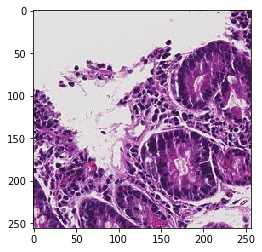

In [8]:
img = plt.imread(f'{PATH}valid/Celiac/{files[0]}')
plt.imshow(img);

In [9]:
arch=resnet50
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 1288/1288 [16:57<00:00,  1.48it/s]


In [10]:
learn.fit(0.001, 4)

epoch      trn_loss   val_loss   accuracy                      
    0      0.255607   0.176581   0.916195  
    1      0.2525     0.16495    0.922615                      
    2      0.222346   0.166147   0.920734                      
    3      0.219628   0.168039   0.919933                      



[0.1680390152543985, 0.9199330145935496]

## Visualising Results

In [11]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 2, 2, 2])

In [12]:
# from here we know that 'Celiac' is label 0 and 'EE' is label 1 and 'Normal' is label 2
data.classes

['Celiac', 'EE', 'Normal']

In [13]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(82406, 3)

Most Correct Celiac


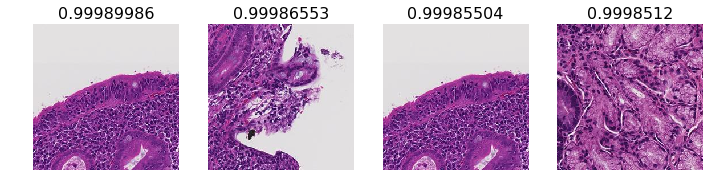

In [14]:
imr = ImageModelResults(data.val_ds, log_preds)
print('Most Correct Celiac')
imr.plot_most_correct(0)

Most Correct EE


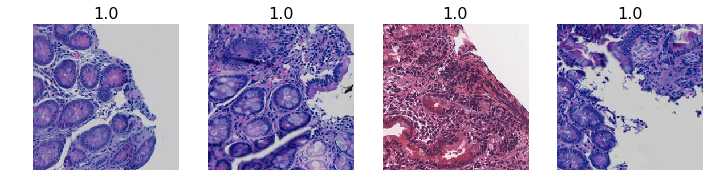

In [15]:
print('Most Correct EE')
imr.plot_most_correct(1)

Most Correct Normal


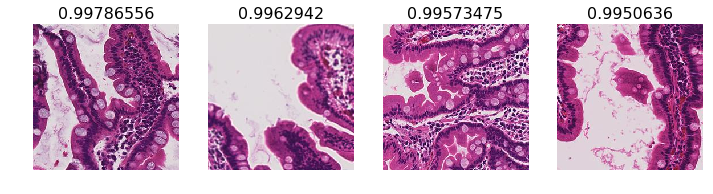

In [16]:
print('Most Correct Normal')
imr.plot_most_correct(2)

Most Incorrect Celiac


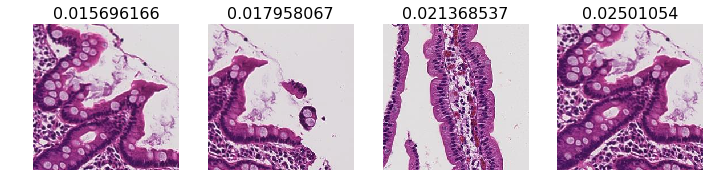

In [17]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

Most Incorrect EE


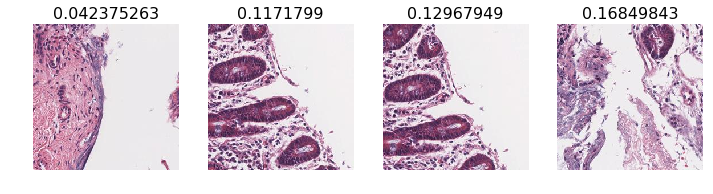

In [18]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

Most Incorrect Normal


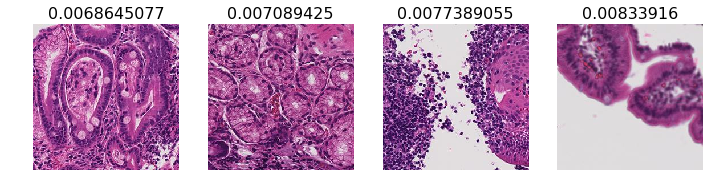

In [19]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

In [20]:
preds = np.argmax(log_preds, axis=1)

In [21]:
y = data.val_y

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[13418     5  1311]
 [    7 51772     5]
 [ 5248    23 10617]]


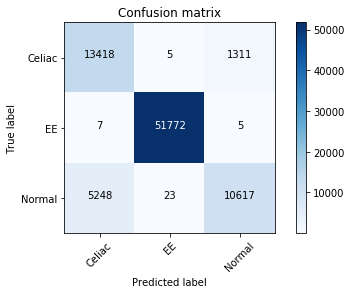

In [23]:
plot_confusion_matrix(cm, data.classes)

## Finding a optimum learning rate

In [24]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [25]:
lrf=learn.lr_find()

 80%|███████▉  | 3441/4324 [00:47<00:15, 56.57it/s, loss=0.998]

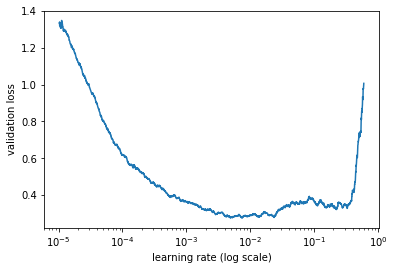

In [26]:
learn.sched.plot()

## Data Augmentation

In [27]:
# Using predefined augmentations transforms_top_down
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

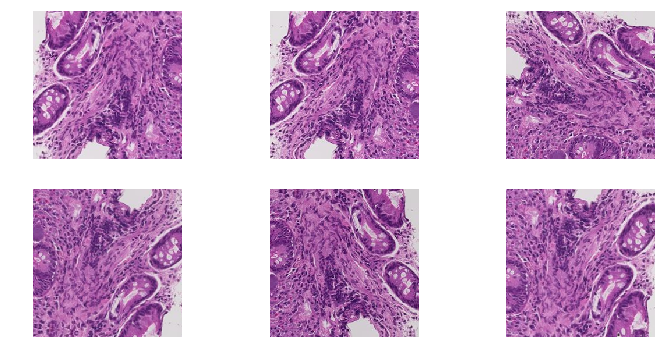

In [28]:
# Visualising the augmentation
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [29]:
# Initializing the data with augmentation and learn method
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.precompute = False

In [30]:
learn.fit(1e-3, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.282335   0.204586   0.902446  
    1      0.270054   0.191031   0.90622                       
    2      0.267291   0.185281   0.911499                      


[0.18528065616678352, 0.911499162670756]

In [33]:
learn.save('256_lastlayer_resnet50')

In [41]:
learn.load('256_lastlayer_resnet50')

## Unfreezing layers and using Differential learning rates

In [42]:
# Unfreeze all layers for training
learn.unfreeze()

In [36]:
lrf=learn.lr_find()

 73%|███████▎  | 3176/4324 [28:27<10:02,  1.91it/s, loss=0.637]

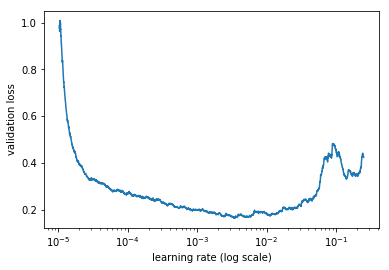

In [37]:
learn.sched.plot()

In [43]:
lr = (1e-4 + 1e-3)/2

In [44]:
lr=np.array([lr/9,lr/3,lr])

In [45]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.176352   0.124629   0.944409  
    1      0.138524   0.103828   0.954773                      
    2      0.129072   0.108139   0.951338                      
    3      0.10783    0.102522   0.954433                       
    4      0.084157   0.096664   0.959081                       
    5      0.081575   0.102453   0.956763                       
    6      0.095267   0.099278   0.957806                       


[0.09927819188140571, 0.95780647041566]

In [46]:
learn.save('256_all_resnet50')
learn.load('256_all_resnet50')

## Analyzing results

### Confusion Matrix and Accuracy with Test Time Augmentation

In [47]:
# Getting log predictions with TTA
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9611921462029464

In [48]:
log_preds.shape

(5, 82406, 3)

In [49]:
log_preds_mean = np.mean(log_preds, 0)

In [53]:
np.save('../data_segments/logpreds_resnet50_all_layers256x256_TTA.npy', log_preds)

In [54]:
preds = np.argmax(probs, axis=1)

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[13819     0   915]
 [    0 51784     0]
 [ 2283     0 13605]]


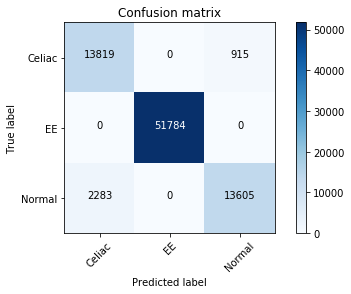

In [56]:
plot_confusion_matrix(cm, data.classes)

### Visualizing results with TTA

Most Correct Celiac


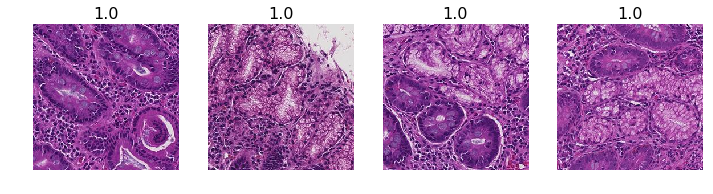

In [57]:
imr = ImageModelResults(data.val_ds, log_preds_mean)
print('Most Correct Celiac')
imr.plot_most_correct(0)

Most Correct EE


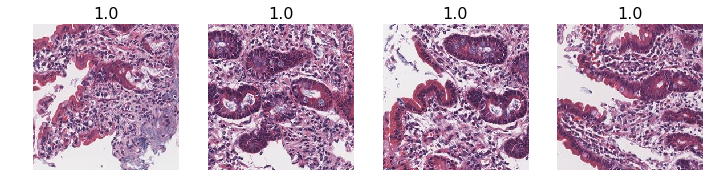

In [58]:
print('Most Correct EE')
imr.plot_most_correct(1)

Most Correct Noraml


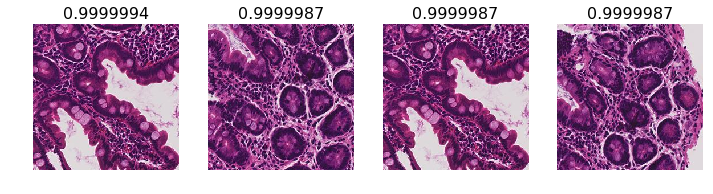

In [59]:
print('Most Correct Noraml')
imr.plot_most_correct(2)

Most Incorrect Celiac


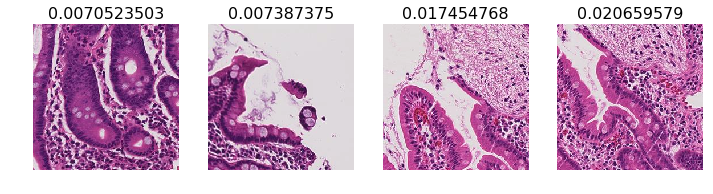

In [60]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

In [61]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

Most Incorrect EE


False

Most Incorrect Normal


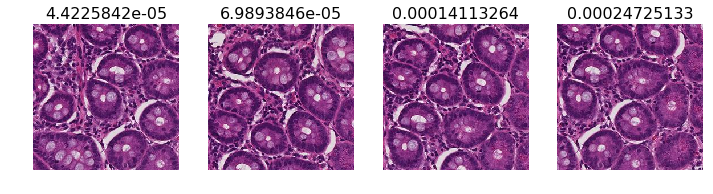

In [62]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

Most Uncertain Celiac


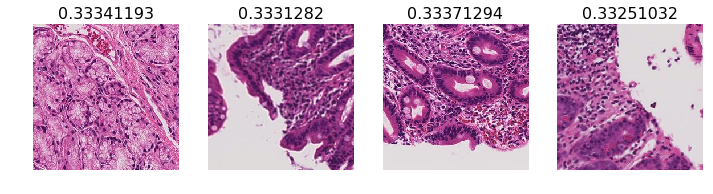

In [63]:
print('Most Uncertain Celiac')
imr.plot_most_uncertain(0)

Most Uncertain EE


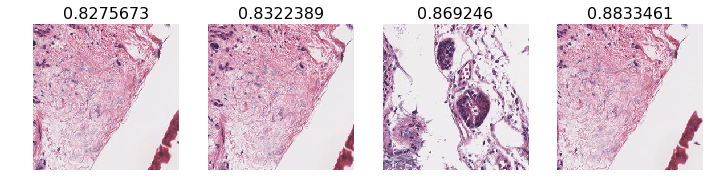

In [64]:
print('Most Uncertain EE')
imr.plot_most_uncertain(1)

Most Uncertain Normal


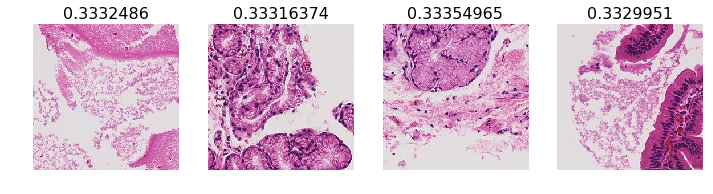

In [65]:
print('Most Uncertain Normal')
imr.plot_most_uncertain(2)

### Confusion Matrix and Accuracy without Test Time Augmentation

In [66]:
# Getting log predictions without TTA
log_preds = learn.predict()

In [67]:
preds = np.argmax(log_preds, axis=1)

In [68]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[13681     0  1053]
 [    0 51783     1]
 [ 2423     0 13465]]


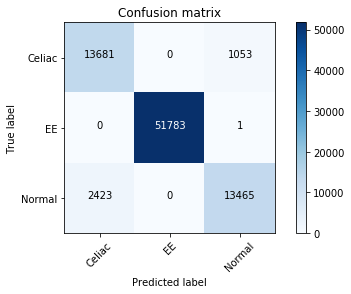

In [69]:
plot_confusion_matrix(cm, data.classes)

In [70]:
"../data_segments/chrc_data_segments/valid/Celiac".split('/')[-2]

'valid'